In [ ]:
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D ,MaxPooling2D,Activation,Flatten,Conv2D,BatchNormalization,Dropout
from tensorflow.keras import layers
from tensorflow.keras import Model
import keras.applications
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/AiLab"

/content/drive/MyDrive/Colab Notebooks/AiLab


In [ ]:
dataset_labels = pd.read_csv('labels.csv')
dataset_labels.head()

,Unnamed: 0,id,label,images,labels
0,0,8228,novo documento,img_0001,1
1,1,8229,mesmo documento,img_0002,0
2,2,8230,novo documento,img_0003,1
3,3,8231,novo documento,img_0004,1
4,4,8232,novo documento,img_0005,1


In [ ]:
dataset_labels = dataset_labels.rename(columns={"label":"annotation","labels":"label"})

In [ ]:
dataset_labels = dataset_labels.loc[:, ~dataset_labels.columns.isin(['Unnamed: 0', 'id', 'images'])]

In [ ]:
dataset_labels

,annotation,label
0,novo documento,1
1,mesmo documento,0
2,novo documento,1
3,novo documento,1
4,novo documento,1
...,...,...
4597,novo documento,1
4598,novo documento,1
4599,novo documento,1
4600,novo documento,1


In [ ]:
dict_df = dataset_labels[['label','annotation']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)

In [ ]:
index_to_label = dict_df.to_dict()['annotation']

In [ ]:
index_to_label

{1: 'novo documento', 0: 'mesmo documento'}

In [ ]:
image_size = (180, 180)
batch_size = 32

In [ ]:
data_dir='/content/drive/MyDrive/Colab Notebooks/AiLab/Dados Osíris'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  labels=dataset_labels['label'].to_numpy().tolist(),
  label_mode='int',
  validation_split=(1/3),
  subset="training",
  image_size= image_size,
  batch_size=batch_size)
 
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  labels=dataset_labels['label'].to_numpy().tolist(),
  label_mode='int',
  validation_split=(1/3),
  subset="validation",
  image_size= image_size,
  batch_size=batch_size)

Found 4602 files belonging to 1 classes.
Using 3068 files for training.
Found 4602 files belonging to 1 classes.
Using 1534 files for validation.


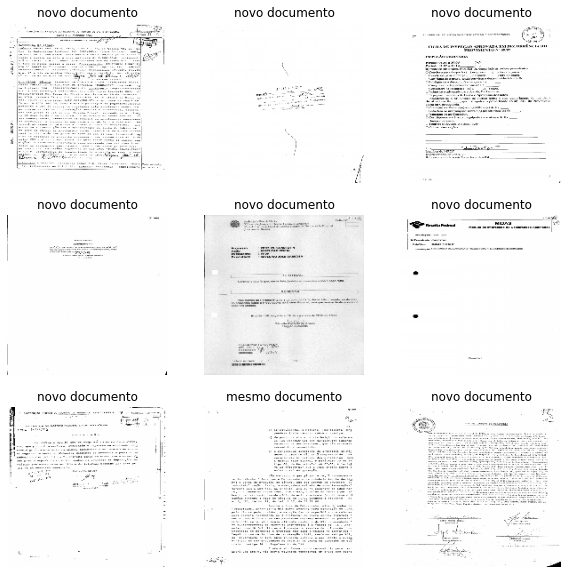

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  lbl=labels.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(index_to_label[lbl[i]])
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

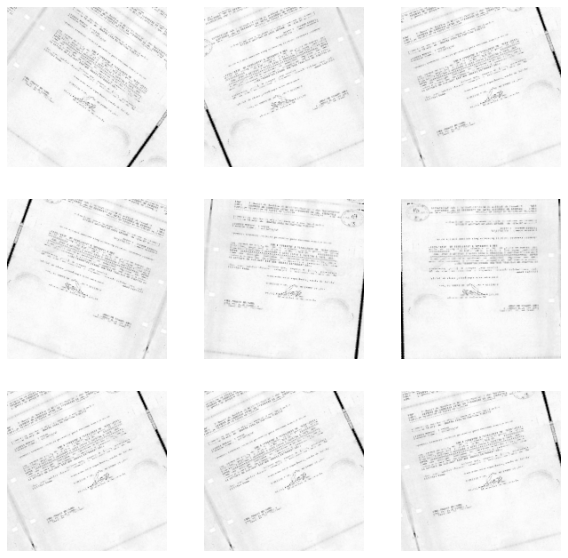

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

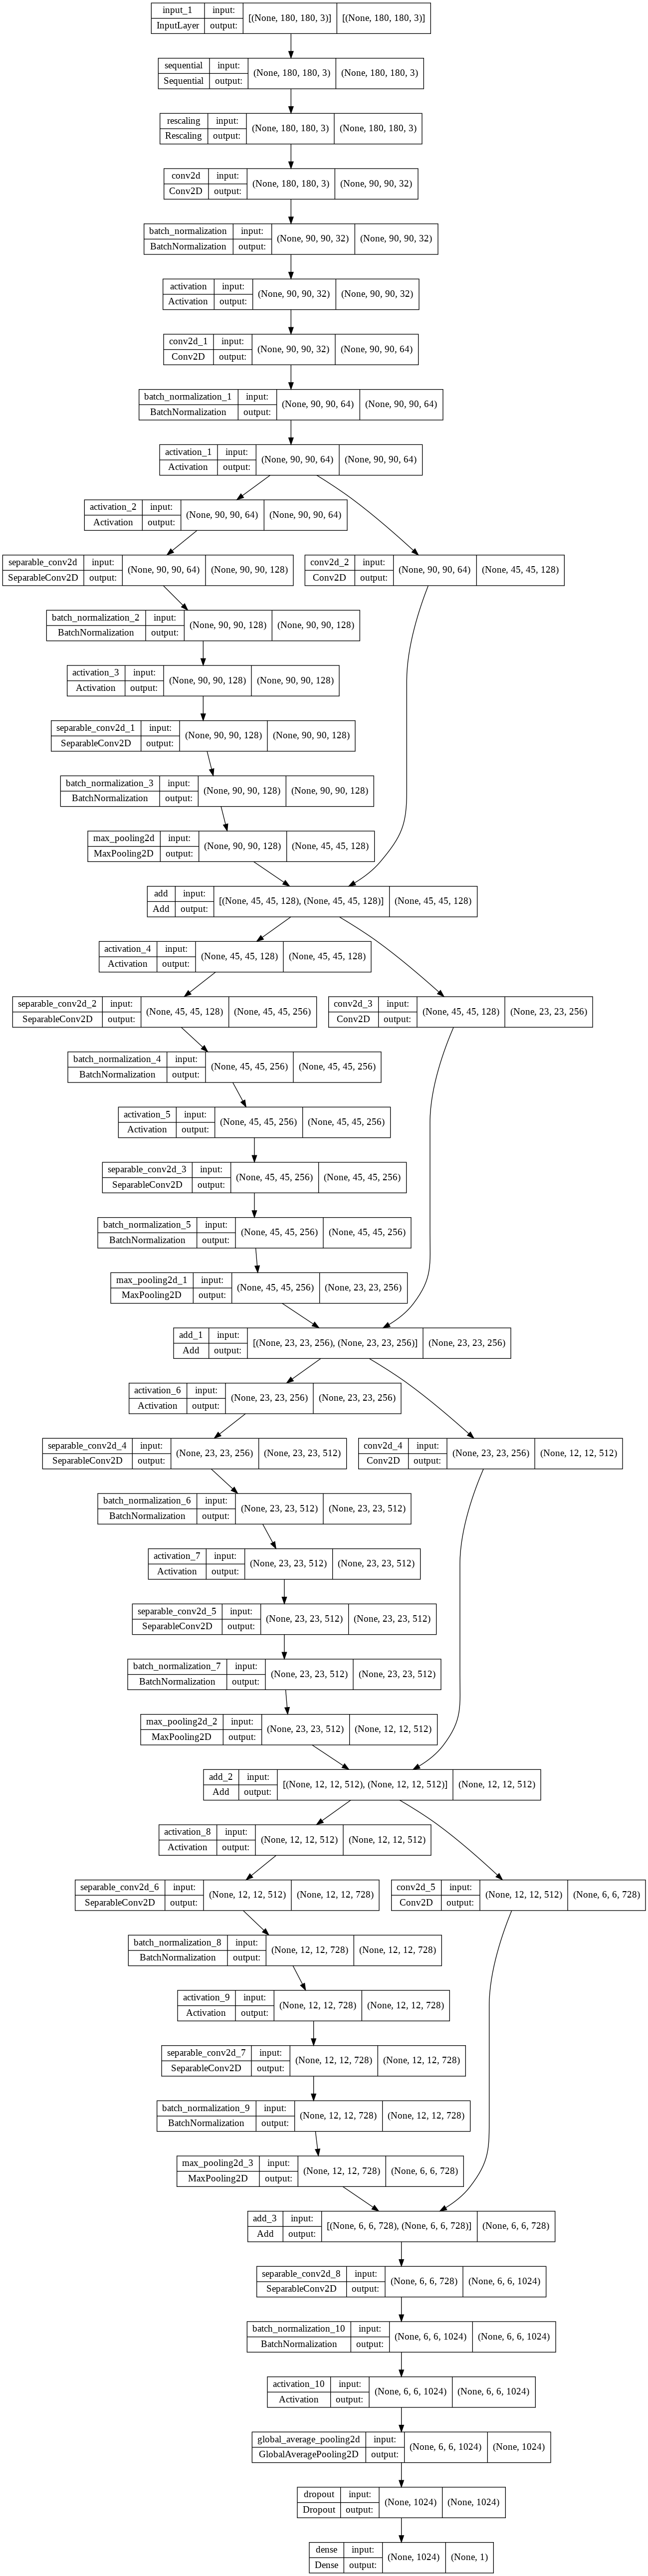

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/15
96/96 [==============================] - 793s 8s/step - loss: 0.4507 - accuracy: 0.8126 - val_loss: 0.5286 - val_accuracy: 0.8194
Epoch 2/15
96/96 [==============================] - 785s 8s/step - loss: 0.4248 - accuracy: 0.8318 - val_loss: 0.4720 - val_accuracy: 0.8194
Epoch 3/15
96/96 [==============================] - 781s 8s/step - loss: 0.4013 - accuracy: 0.8286 - val_loss: 0.5057 - val_accuracy: 0.8194
Epoch 4/15
96/96 [==============================] - 778s 8s/step - loss: 0.3796 - accuracy: 0.8468 - val_loss: 0.5195 - val_accuracy: 0.8194
Epoch 5/15
96/96 [==============================] - 781s 8s/step - loss: 0.3740 - accuracy: 0.8517 - val_loss: 0.5663 - val_accuracy: 0.8207
Epoch 6/15
96/96 [==============================] - 789s 8s/step - loss: 0.3558 - accuracy: 0.8569 - val_loss: 0.5817 - val_accuracy: 0.8364
Epoch 7/15
96/96 [==============================] - 782s 8s/step - loss: 0.3569 - accuracy: 0.8530 - val_loss: 0.3849 - val_accuracy: 0.8370
Epoch 8/15
96